<a href="https://colab.research.google.com/github/mukkatharun/advance-deep-learning-assignments/blob/main/assignment3_Multi%20Task%20Learning%20and%20Transfer%20Learning/transferlearning_using_head2toe_technique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Head2Toe

In [1]:
!git clone https://github.com/google-research/head2toe.git

Cloning into 'head2toe'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 90 (delta 32), reused 53 (delta 19), pack-reused 22
Unpacking objects: 100% (90/90), done.


In [2]:
!pip install colab-xterm
%load_ext colabxterm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115 kB 18.5 MB/s 


In [3]:
%reload_ext colabxterm

Setup the terminal using the steps given the readme file

Run the below command in xterm 

```
python head2toe/evaluate.py \
  --config=head2toe/configs_eval/finetune_h2t.py:imagenetr50 \
  --config.dataset='data.cifar' \
  --config.eval_mode='test' --config.learning.cached_eval=False \
  --config.backbone.additional_features_target_size=512 \
  --config.learning.feature_selection.keep_fraction=0.01 \
  --config.learning.feature_selection.learning_config_overwrite.group_lrp_regularizer_coef=0.00001 \
  --config.learning.learning_rate=0.1 --config.learning.training_steps=2000 \
  --config.learning.log_freq=1000
```



In [8]:
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

**Results of Head2Toe transfer learning implementation**

  first images gives the details of layers and and second image shows the mdoel metrics

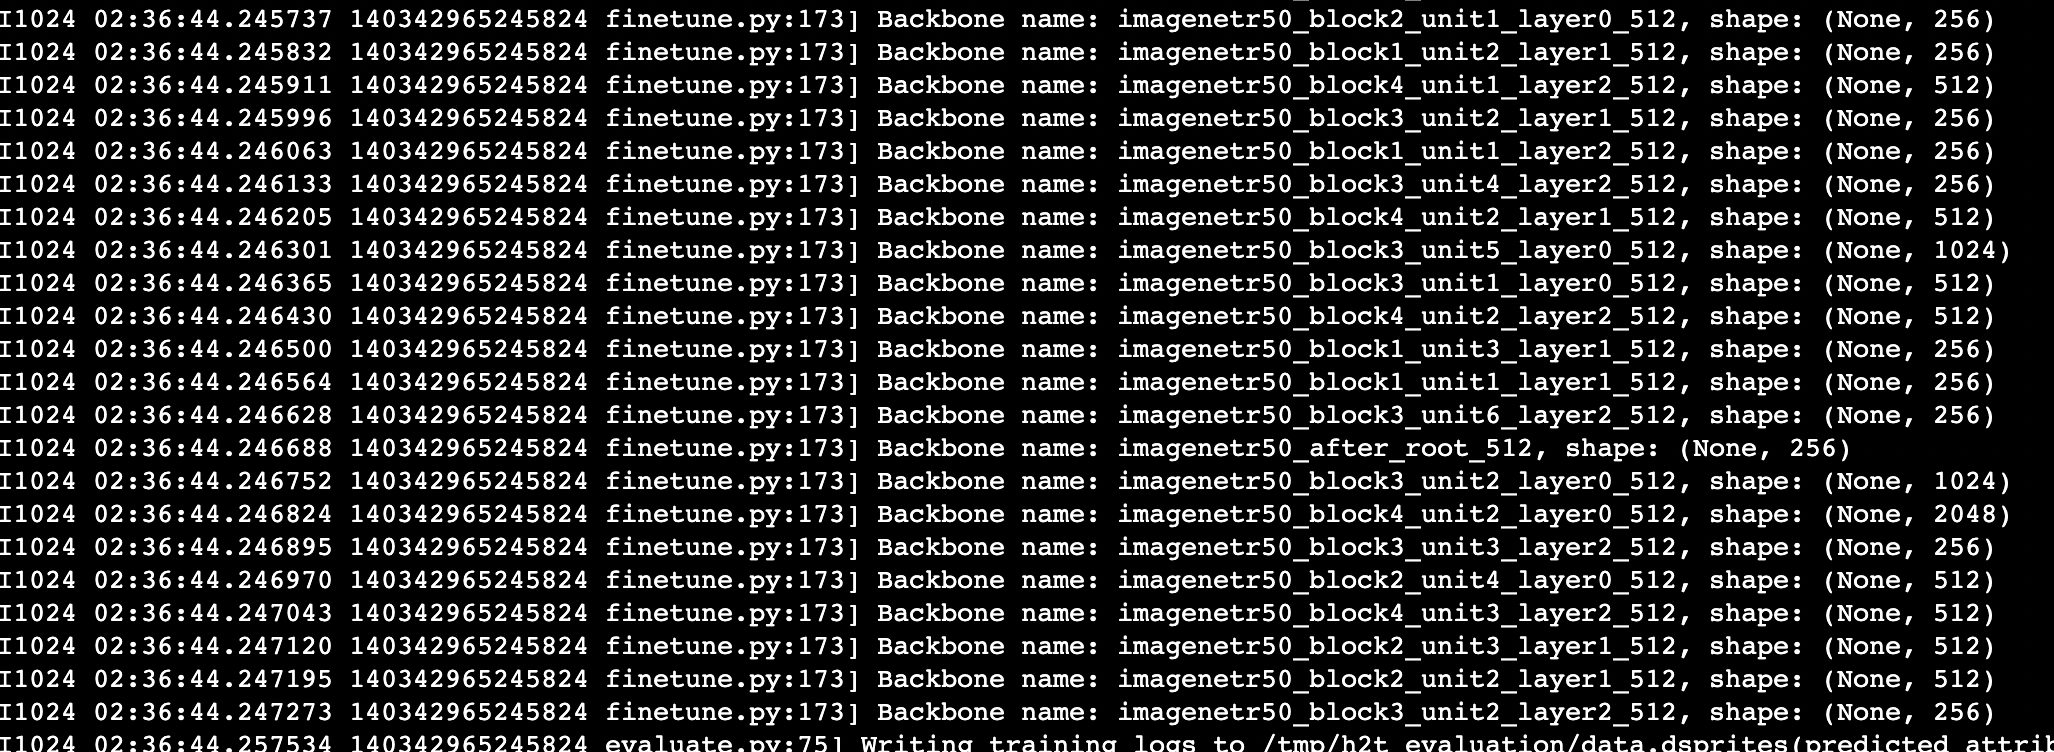

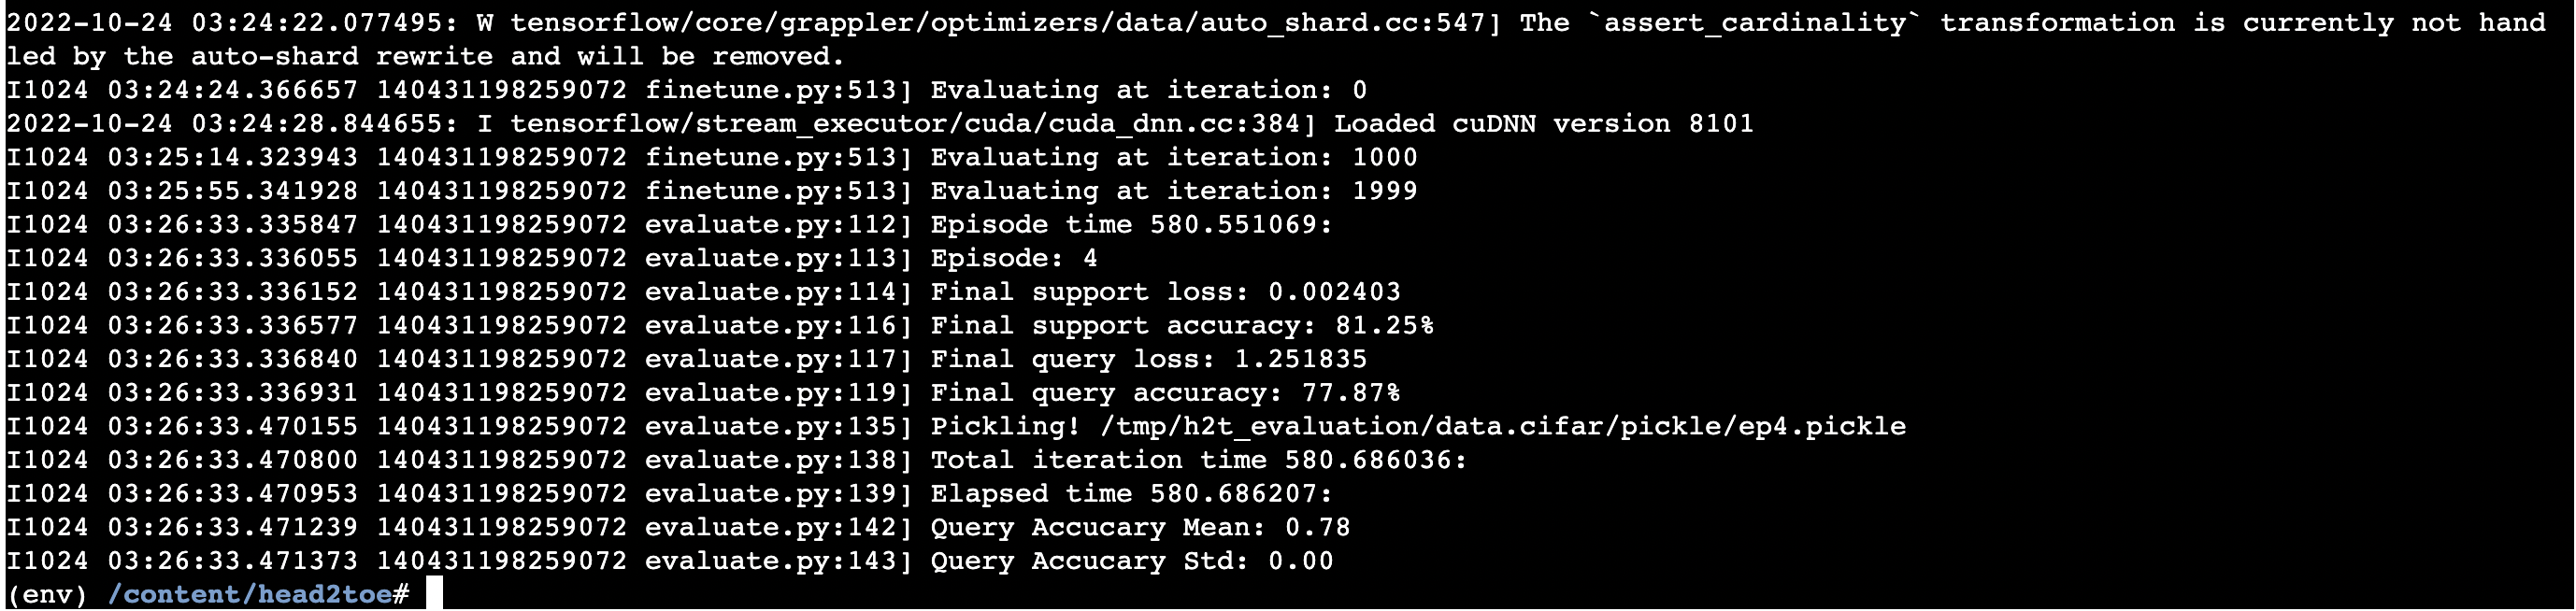

##Transfer Learning using imagenet

In [9]:
import tensorflow.keras as K
import tensorflow as tf

In [10]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [11]:
def preprocess_data(X, Y):
    """
    Pre-processes the data for the model

        :param X: numpy.ndarray of shape (m, 32, 32, 3)
            containing the CIFAR 10 data, where m is the
            number of data points

        :param Y: numpy.ndarray of shape (m,) containing
            the CIFAR 10 labels for X

        :returns: X_p, Y_p
    """
    X_p = K.applications.densenet.preprocess_input(X)

    # encode to one-hot
    Y_p = K.utils.to_categorical(Y, 10)
    return X_p, Y_p

In [16]:
CALLBACKS = []
MODEL_PATH = 'cifar10.h5'
optimizer = K.optimizers.Adam()

# load cifar 10
(x_train, y_train), (x_test, y_test) = K.datasets.cifar10.load_data()

# pre-procces data
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

# input tensor
inputs = K.Input(shape=(32, 32, 3))

# upscale layer
upscale = K.layers.Lambda(lambda x: tf.compat.v1.image.resize_image_with_pad(x,160,160,
                                                                  method=tf.image.ResizeMethod.BILINEAR))(inputs)

# load base model
base_model = K.applications.DenseNet121(include_top=False,
                                        weights='imagenet',
                                        input_tensor=upscale,
                                        input_shape=(160,160,3),
                                        pooling='max')



# add top layers
out = base_model.output
out = K.layers.Flatten()(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(256, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(128, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(64, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.Dense(10, activation='softmax')(out)

# callbacks
CALLBACKS.append(K.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_acc',
                                              save_best_only=True))

CALLBACKS.append(K.callbacks.EarlyStopping(monitor='val_acc',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(K.callbacks.TensorBoard(log_dir='logs'))

# model compile
model = K.models.Model(inputs=inputs, outputs=out)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# train
model.fit(x=x_train,
          y=y_train,
          batch_size=128,
          epochs=5,
          callbacks=CALLBACKS,
          validation_data=(x_test, y_test))

Epoch 1/5
391/391 [==============================] - ETA: 0s - loss: 0.8521 - accuracy: 0.7213

391/391 [==============================] - 326s 802ms/step - loss: 0.8521 - accuracy: 0.7213 - val_loss: 0.6921 - val_accuracy: 0.8001
Epoch 2/5
391/391 [==============================] - ETA: 0s - loss: 0.3793 - accuracy: 0.8847

391/391 [==============================] - 311s 795ms/step - loss: 0.3793 - accuracy: 0.8847 - val_loss: 0.3560 - val_accuracy: 0.8831
Epoch 3/5
391/391 [==============================] - ETA: 0s - loss: 0.2909 - accuracy: 0.9104

391/391 [==============================] - 311s 795ms/step - loss: 0.2909 - accuracy: 0.9104 - val_loss: 0.3783 - val_accuracy: 0.8762
Epoch 4/5
391/391 [==============================] - ETA: 0s - loss: 0.2398 - accuracy: 0.9258

391/391 [==============================] - 311s 795ms/step - loss: 0.2398 - accuracy: 0.9258 - val_loss: 0.4688 - val_accuracy: 0.8570
Epoch 5/5
391/391 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 0.9360

391/391 [==============================] - 310s 793ms/step - loss: 0.2075 - accuracy: 0.9360 - val_loss: 0.5130 - val_accuracy: 0.8528


**Conclusion:**

As the results shown that Head2Toe model acheived 81% accuracy when performed on a subset of large dataset but the regular transfer-learning model acheived accuracy of 85% when trained on whole dataset. This gives more leverage to Head2Toe model to improve the performance by modifying the hyper-parameters and increasing the subset.